# Audio track genre analysis with Spotify API
---

In [1]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import requests
import pandas as pd
from pydub import AudioSegment 
from io import BytesIO
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Javascript, display

In [2]:
# Set up credentials
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id='2ecbd11c2910489f808922680838741c',
                                               client_secret='7f9d2926b673419ba14789f4e46d35af',
                                               redirect_uri='http://localhost:8888/callback',
                                               scope='playlist-read-private'))

## Data Extraction, Processing, Cleaning

Downloading 30-second snippets of tracks in a playlist:

In [ ]:
"""
This cell extracts and downloads 30 second snippets of all songs in specified playlist
Tracks stored in ./spotify_samples in .wav file format
"""

# Access your playlist (replace 'drive' with your playlist name or ID)
playlist_name = 'drive'
playlists = sp.current_user_playlists()

# Find the 'drive' playlist
playlist_id = None
for playlist in playlists['items']:
    if playlist['name'].lower() == playlist_name.lower():
        playlist_id = playlist['id']
        break

if playlist_id is None:
    print(f"Playlist '{playlist_name}' not found!")
else:
    # Initialize pagination variables
    limit = 100  # Max number of tracks Spotify allows in one call
    offset = 0
    all_tracks = []

    # Fetch all tracks by paginating through the playlist
    while True:
        playlist_tracks = sp.playlist_tracks(playlist_id, limit=limit, offset=offset)
        all_tracks.extend(playlist_tracks['items'])
        
        if len(playlist_tracks['items']) < limit:
            break  # Exit loop when there are no more tracks to fetch

        offset += limit  # Move to the next set of tracks

    print(f"Found {len(all_tracks)} tracks in the playlist.")

    # Process each track to download preview
    for i, track in enumerate(all_tracks):
        track_name = track['track']['name']
        preview_url = track['track']['preview_url']

        if preview_url:
            print(f"Downloading preview for: {track_name}")

            # Download the preview using requests
            audio_data = requests.get(preview_url).content

            # Convert MP3 to WAV using pydub
            audio_segment = AudioSegment.from_file(BytesIO(audio_data), format="mp3")
            wav_file = f"{track_name}.wav"
            audio_segment.export('spotify_samples/'+wav_file, format="wav")
            print(f"Saved as {wav_file}")
        else:
            print(f"No preview available for {track_name}")

Extracting tracks in a playlist and storing (Track name, Artist, Genre) in a Pandas Dataframe:

In [3]:
"""
This cell extracts all the tracks in specified playlist and stores
Track name, Artist, Genre in a Pandas dataframe.
A .csv file of the data is optionally saved
"""

# Get playlist information
playlist_name = 'drive'
username = 'smozaffar98'  # Your Spotify username
playlist_id = None

# Fetch user playlists to get the playlist ID for playlist
playlists = sp.user_playlists(user=username)
for playlist in playlists['items']:
    if playlist['name'].lower() == playlist_name.lower():
        playlist_id = playlist['id']
        break

if playlist_id is None:
    raise ValueError(f"Playlist '{playlist_name}' not found.")

# Initialize pagination variables
limit = 100  # Max number of tracks Spotify allows in one call
offset = 0
all_tracks = []

# Fetch all tracks by paginating through the playlist
while True:
    playlist_tracks = sp.playlist_tracks(playlist_id, limit=limit, offset=offset)
    all_tracks.extend(playlist_tracks['items'])
    
    if len(playlist_tracks['items']) < limit:
        break  # Exit loop when there are no more tracks to fetch

    offset += limit  # Move to the next set of tracks

print(f"Found {len(all_tracks)} tracks in the playlist.")

# Extract track details into a list of dictionaries
track_data = []
for track in all_tracks:
    track_info = track['track']
    track_name = track_info['name']
    track_artist = track_info['artists'][0]['name']
    track_genre = "Unknown"  # Default to unknown if no genre is found

    # Fetch artist details to extract genre
    artist_id = track_info['artists'][0]['id']
    artist_info = sp.artist(artist_id)
    if 'genres' in artist_info and artist_info['genres']:
        track_genre = ', '.join(artist_info['genres'])  # Combine genres if multiple

    # Append track details to the list
    track_data.append({
        'Track Name': track_name,
        'Artist': track_artist,
        'Genres': track_genre
    })

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(track_data)

# Optionally, save the DataFrame to a CSV file
#df.to_csv('drive_playlist_eda.csv', index=False)

Found 471 tracks in the playlist.


Omit all tracks with genre 'Unknown':

In [4]:
"""
This cell cleans the data and omits tracks which have 'unknown' genre
"""

# Count rows with 'Unknown' genre
unknown_genres_count = df[df['Genres'] == 'Unknown'].shape[0]
print(f"Number of tracks with 'Unknown' genre: {unknown_genres_count}")

# Remove rows with 'Unknown' genre
df_cleaned = df[df['Genres'] != 'Unknown']

# Print the number of rows after cleaning
print(f"Number of tracks after removing 'Unknown' genre: {df_cleaned.shape[0]}")

Number of tracks with 'Unknown' genre: 28
Number of tracks after removing 'Unknown' genre: 443


## Plotting

First few rows of the dataset:
                              Track Name       Artist               Genres
0                             Swing Lynn     Harmless     modern dream pop
1             The Less I Know The Better  Tame Impala     australian psych
2                                  Young    Vacations  newcastle nsw indie
3  Black Out Days - Future Islands Remix   Phantogram         indietronica
4                           High You Are  What So Not        aussietronica

Missing values in each column:
Track Name    0
Artist        0
Genres        0
dtype: int64

Descriptive Statistics:
       Track Name      Artist            Genres
count         443         443               443
unique        436         320               195
top       Massive  ROLE MODEL  alternative rock
freq            2           8                18


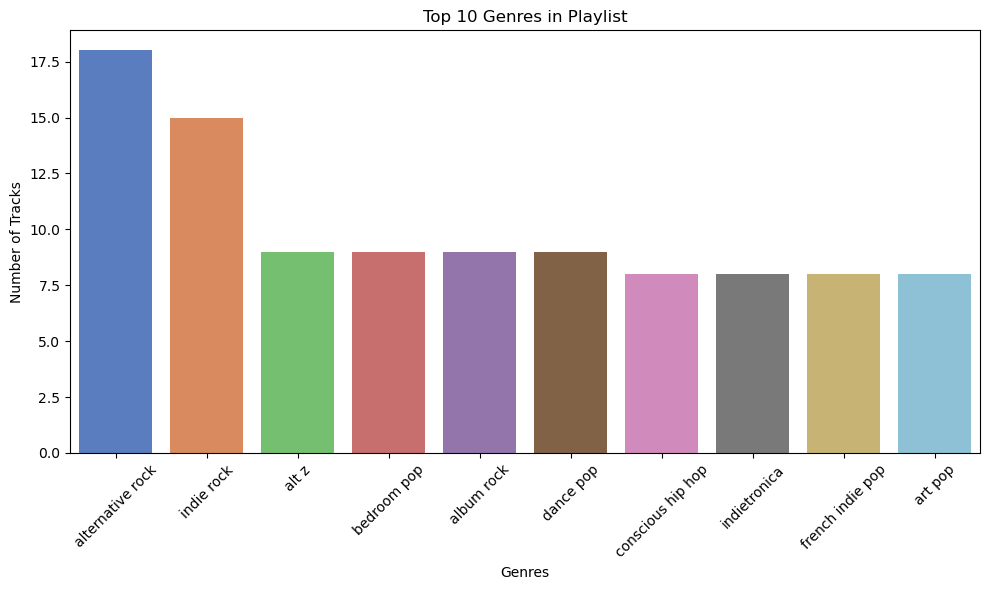

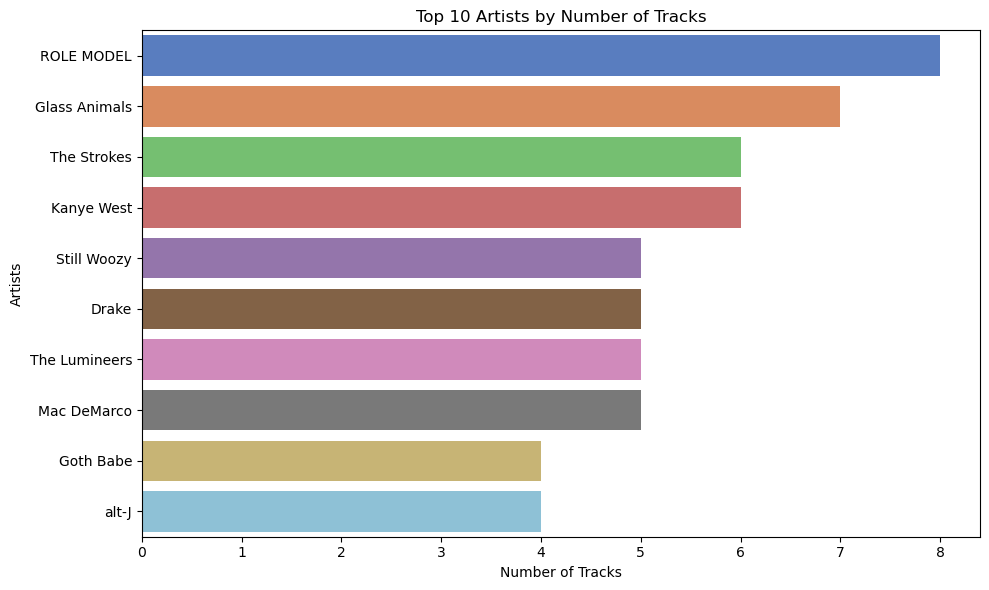

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Display the first few rows of the DataFrame
print("First few rows of the dataset:")
print(df_cleaned.head())

# Check for missing values
print("\nMissing values in each column:")
print(df_cleaned.isnull().sum())

# Basic descriptive statistics
print("\nDescriptive Statistics:")
print(df_cleaned.describe(include='all'))

# Grouping by genres and counting the occurrences
df_cleaned['Genres'] = df_cleaned['Genres'].apply(lambda x: x.split(', ')[0] if x != "Unknown" else "Unknown")
genre_counts = df_cleaned['Genres'].value_counts().head(10)  # Select top 10 most frequent genres

plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='muted')
plt.xlabel('Genres')
plt.ylabel('Number of Tracks')
plt.title('Top 10 Genres in Playlist')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Count top 10 artists
artist_counts = df_cleaned['Artist'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(y=artist_counts.index, x=artist_counts.values, palette='muted')
plt.xlabel('Number of Tracks')
plt.ylabel('Artists')
plt.title('Top 10 Artists by Number of Tracks')
plt.tight_layout()
plt.show()


The dataset initially had 443 tracks with the following key statistics:

- **Unique Artists**: 320
- **Unique Genres**: 299
- **Top Artists**: ROLE MODEL, Glass Animals, The Strokes
- **Tracks with Missing Genre Information**: 0
- No missing values for the "Track Name", "Artist", and "Genres" columns.

### Summary Statistics
The following statistics summarize the playlist:
- **Most Frequent Artist**: ROLE MODEL and Glass Animals, with 8 tracks each.
- **Most Frequent Genres**: Alternative Rock, Indie Rock, Alt Z.

### Genre Distribution
The genre distribution was highly varied, with 299 distinct genres associated with the artists. Analysis focused on the top genres to reduce clutter.

- **Top Genres**:
    - Alternative Rock
    - Indie Rock
    - Alt Z
    - Bedroom Pop

**Observations**:
- **Diverse Genres**: A wide range of genres are present in the playlist, but most of the tracks cluster into a few popular genres.
- **Unknown Genres**: There are tracks with "Unknown" genres that were filtered out during the cleaning process.


### Key Insights:
- **Genres**: Alternative Rock dominates the playlist, followed by Indie Rock and Alt Z. Bedroom Pop, a more niche genre, also has significant representation, reflecting a blend of mainstream and indie music preferences.
- **Artists**: ROLE MODEL leads in terms of track contribution, indicating a personal preference for this artist. Similarly, Glass Animals, The Strokes, and Kanye West are also frequently featured.


---
# Genre Prediction with Trained Model

First, we need to create a text file that contains the pathnames to all the audio files

In [2]:
import os
import random

"""
This script processes the spotify_samples/ folder, 
shuffles the songs, and saves them into a single 
spotify_tracks_list.txt file.
"""

# Path to the dataset
dataset_path = "/Users/shawyan/Desktop/Data Portfolio/Genre-Classifer/spotify_samples"

# Path for saving the songs list
songs_list_file = "spotify_tracks_list.txt"

# Initialize list for all songs
all_songs = []

# Process the dataset folder
for file in os.listdir(dataset_path):
    file_path = os.path.join(dataset_path, file)
    if file.endswith(".wav"):  # Only consider .wav files
        all_songs.append(file_path)

# Shuffle the songs
random.shuffle(all_songs)

# Write the list of all songs to spotify_tracks_list.txt
with open(songs_list_file, 'w') as f:
    for song in all_songs:
        f.write(f"{song}\n")

print(f"All songs list saved to {songs_list_file}")

All songs list saved to spotify_tracks_list.txt


Then, we can get the mel-spectrograms for each audio file, initialize model, and load the trained weights

In [3]:
from genre_net import Genrefier_CRNN
from utils import *
import torch
from torch.utils.data import DataLoader, TensorDataset
import librosa

sample_list_path = "/Users/shawyan/Desktop/Data Portfolio/Genre-Classifer/track_lists/spotify_tracks_list.txt"

# Mel-spectrogram extraction function
def extract_melgrams_spotify(list_path, MULTIFRAMES, process_all_song):
    melgrams = np.zeros((0, 1, 96, 1366), dtype=np.float32)
    song_paths = open(list_path, 'r').read().splitlines()
    num_frames_total = []

    print("Starting Melgram Extraction")

    for song_path in song_paths:

        # Compute mel-spectrogram
        if MULTIFRAMES:
            melgram = compute_melgram_multiframe(song_path, process_all_song)
        else:
            melgram = compute_melgram(song_path)

        if melgram is None:  # Skip this file if melgram is None
            print(f"Skipping {song_path} due to loading error.")
            continue

        num_frames = melgram.shape[0]
        num_frames_total.append(num_frames)

        melgrams = np.concatenate((melgrams, melgram), axis=0)

    print("Melgram Extraction Complete")
    return melgrams, num_frames_total

# Set device to MPS or CPU
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

model = Genrefier_CRNN().to(device)
model.load_state_dict(torch.load("/Users/shawyan/Desktop/Data Portfolio/Genre-Classifer/models_trained/crnn_classifier_epoch_100.pth"))

# Extract mel-spectrograms
X_test, num_frames_test = extract_melgrams_spotify(sample_list_path, MULTIFRAMES=1, process_all_song=True)
X_test = torch.tensor(X_test, dtype=torch.float32).view(-1, 1, 96, 1366).to(device)


# Initialize Data-Loader
test_dataset = TensorDataset(X_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

predictions = []

 # Disable gradient calculations
with torch.no_grad():
    for batch in test_loader:
        batch_X = batch[0]
        
        # Move batch data to the correct device
        batch_X = batch_X.to(device)

        # Forward pass 
        outputs = model(batch_X)

        # Get predicted labels (select class with highest probability)
        _, predicted = torch.max(outputs, dim=1)

        # Collect predictions and true labels
        predictions.extend(predicted.cpu().numpy())

Starting Melgram Extraction
Melgram Extraction Complete


Now, using the predicted genres, we can view a distribution of genres within the playlist

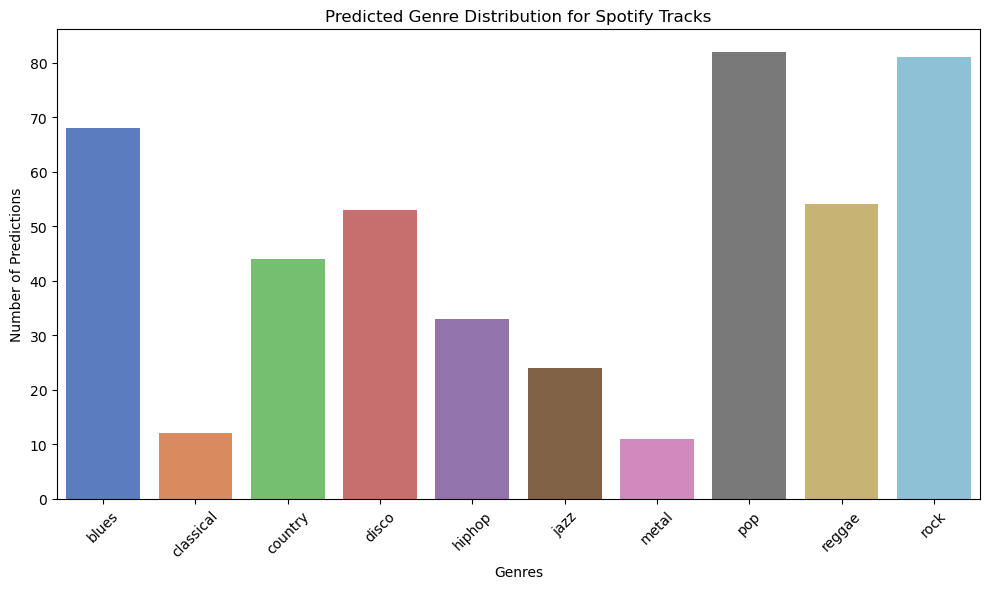

In [15]:
# Labels
genre_labels = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

# Count the occurrences of each prediction (bin the predictions)
prediction_counts = np.bincount(predictions, minlength=len(genre_labels))

# Plotting the distribution of predictions
def plot_genre_distribution(prediction_counts, genre_labels):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=genre_labels, y=prediction_counts, palette='muted')
    plt.xlabel('Genres')
    plt.ylabel('Number of Predictions')
    plt.title('Predicted Genre Distribution for Spotify Tracks')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_genre_distribution(prediction_counts, genre_labels)


In [5]:
# Labels
genre_labels = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

predictions_df = pd.DataFrame({
    'Predicted Genre': [genre_labels[pred] for pred in predictions]
})

# Display descriptive statistics
def descriptive_stats(predictions_df):
    print("Descriptive Statistics of Predicted Genres:\n")
    
    # Total number of predictions
    total_predictions = predictions_df['Predicted Genre'].count()
    print(f"Total Predictions: {total_predictions}\n")

    # Unique genres predicted
    unique_genres = predictions_df['Predicted Genre'].nunique()
    print(f"Unique Genres Predicted: {unique_genres}\n")

    # Count of predictions for each genre
    genre_counts = predictions_df['Predicted Genre'].value_counts()
    print("Predictions Count per Genre:\n")
    print(genre_counts)

    # Percentage breakdown of genres
    genre_percentages = (genre_counts / total_predictions) * 100
    print("\nPercentage Breakdown of Predicted Genres:\n")
    print(genre_percentages)

    # Summary of the statistics (mean, std, etc.)
    print("\nSummary Statistics of Genre Predictions:\n")
    print(predictions_df.describe(include='all'))

# Call the function to print descriptive stats
descriptive_stats(predictions_df)

Descriptive Statistics of Predicted Genres:

Total Predictions: 462

Unique Genres Predicted: 10

Predictions Count per Genre:

Predicted Genre
pop          82
rock         81
blues        68
reggae       54
disco        53
country      44
hiphop       33
jazz         24
classical    12
metal        11
Name: count, dtype: int64

Percentage Breakdown of Predicted Genres:

Predicted Genre
pop          17.748918
rock         17.532468
blues        14.718615
reggae       11.688312
disco        11.471861
country       9.523810
hiphop        7.142857
jazz          5.194805
classical     2.597403
metal         2.380952
Name: count, dtype: float64

Summary Statistics of Genre Predictions:

       Predicted Genre
count              462
unique              10
top                pop
freq                82


From EDA, it is apparent that subgenres of *Rock* and *Pop* such as *alternative rock, indie rock, album rock, bedroom pop, dance pop, french indie pop, and art pop* dominate the playlist. The model predicted that *Rock* and *Pop* were the two genres that were most frequent in the playlist, with each genre making up 17% of the tracks in the playlist. From the model's confusion matrix, we know that the *Blues* genre shows moderate confusion with *Rock*, possibly due to overlapping acoustic characteristics. This is perhaps also visualized in the predictions of the Spotify playlist, as *Blues* was predicted to be the third most frequent genre; the model could have falsely classified certain *Rock* tracks as *Blues*. Since the model achieved AUC scores above **0.90** for the genres *Classical*, *Jazz*, and *Metal*, there is a high probability that they truly are the minority genres in the Spotify playlist. Since the model achieved AUC scores around **0.80** for the genres *Rock* and *Blues*, indicating a tendency for misclassification in these genres, we can not be certain that the model predicts the correct distribution of these genres in the Spotify playlist.  